In [37]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary
from torchvision.transforms import Grayscale
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt

# Getting data

In [38]:
scale = 32
distortion_scale = 0.3

orig_transform = transforms.Compose([
  transforms.Resize((scale, scale)),
  Grayscale(num_output_channels=1),  
  transforms.ToTensor(),
  transforms.Normalize(mean=(0.1307), std=(0.3081))
])

data_aug_transform = transforms.Compose([
  transforms.Resize((scale, scale)),
  Grayscale(num_output_channels=1),
  transforms.ToTensor(),
  transforms.RandomRotation((-45, 45)),
  transforms.RandomPerspective(distortion_scale=distortion_scale, p=0.5),
  transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

In [40]:
orig_train_data = datasets.CIFAR10(root='./data', train=True, transform=orig_transform, download=True)
test_data = datasets.CIFAR10(root='./data', train=False, transform=orig_transform, download=True)

augmented_train_data = datasets.CIFAR10(root='./data', train=True, transform=data_aug_transform, download=False)

train_data = torch.utils.data.ConcatDataset([orig_train_data, augmented_train_data])

Files already downloaded and verified
Files already downloaded and verified


In [41]:
print("original train data length:", len(orig_train_data))
print("augmented train data length:", len(augmented_train_data))
print("combined train data length:", len(train_data))

original train data length: 50000
augmented train data length: 50000
combined train data length: 100000


# Train/Test split

In [42]:
batch = 64

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch, shuffle=True, num_workers=0)

# Visualization

In [43]:
data_dict = {0 : "Airplane",
             1 : "Car",
             2 : "Bird",
             3 : "Cat",
             4 : "Deer",
             5 : "Dog",
             6 : "Frog",
             7 : "Horse",
             8 : "Ship",
             9 : "Truck",
            }

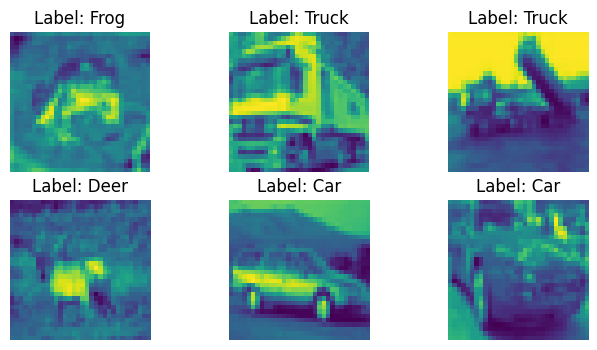

In [44]:
fig, axes = plt.subplots(2, 3, figsize=(8, 4))

for i in range(6):
  img, label = orig_train_data[i]
  row, col = i // 3, i % 3
  axes[row, col].imshow(img.permute(1, 2, 0))
  axes[row, col].set_title(f"Label: {data_dict[label]}")
  axes[row, col].axis('off')

# Models

In [15]:
def training(model, opt, criterion, train_loader, val_loader, epochs=10):
  train_acc, train_loss, val_acc, val_loss, = [], [], [], []

  for epoch in range(epochs):
    running_loss = running_loss_val = 0.0
    total = total_val = correct = correct_val = 0

    # Training
    for inputs, labels in train_loader: # Loop through every batch
        labels = labels.type(torch.LongTensor) 
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Reset gradient
        optimizer.zero_grad()

        # Feedforward
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backprop
        loss.backward()
        optimizer.step()

        # Get prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Accumulate loss
        running_loss += loss.item()

    accuracy = 100 * correct / total
    train_acc.append(accuracy)

    avg_loss = running_loss / len(train_loader)
    train_loss.append(avg_loss)

    # Validation
    with torch.no_grad():
      for inputs_val, labels_val in val_loader:
        labels_val = labels_val.type(torch.LongTensor) 
        inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)

        outputs_val = model(inputs_val)
        loss_val = criterion(outputs_val, labels_val)

        _, predicted_val = torch.max(outputs_val.data, 1)
        total_val += labels_val.size(0)
        correct_val += (predicted_val == labels_val).sum().item()

        running_loss_val += loss_val.item()

      accuracy_val = 100 * correct_val / total_val
      avg_loss_val = running_loss_val / len(val_loader)
      val_acc.append(accuracy_val)
      val_loss.append(avg_loss_val)

    print("The loss for Epoch {} is: {}, Accuracy = {}".format(epoch, running_loss/len(train_loader), accuracy))
  return train_acc, train_loss, val_acc, val_loss

## Logistic Regression

In [45]:
class LogReg(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.linear = nn.Linear(in_features=32*32, out_features=10, bias=True)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    return self.sigmoid(self.linear(self.flatten(x)))


In [46]:
log_model = LogReg()
optimizer = optim.Adam(log_model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
epochs = 10

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
log_model.to(device)

LogReg(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=1024, out_features=10, bias=True)
  (sigmoid): Sigmoid()
)

In [50]:
train_acc_log, train_loss_log, val_acc_log, val_loss_log = training(log_model, optimizer, criterion, train_loader, test_loader, epochs=epochs)

The loss for Epoch 0 is: 2.2555854306797607, Accuracy = 15.982
The loss for Epoch 1 is: 2.22520469078557, Accuracy = 19.047
The loss for Epoch 2 is: 2.210896541427056, Accuracy = 20.168
The loss for Epoch 3 is: 2.201835111555806, Accuracy = 20.61
The loss for Epoch 4 is: 2.195538188277798, Accuracy = 21.326
The loss for Epoch 5 is: 2.1906508682480395, Accuracy = 21.71
The loss for Epoch 6 is: 2.18687934655832, Accuracy = 22.147
The loss for Epoch 7 is: 2.1843299063367105, Accuracy = 22.251
The loss for Epoch 8 is: 2.1814101964178105, Accuracy = 22.406
The loss for Epoch 9 is: 2.17935739521483, Accuracy = 22.697


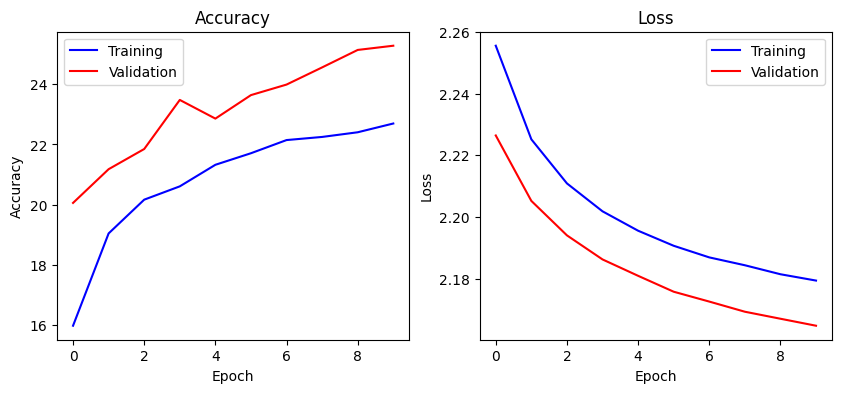

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].set_title("Accuracy")
axes[0].plot(range(epochs), train_acc_log, 'b', label='Training')
axes[0].plot(range(epochs), val_acc_log, 'r', label='Validation')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].legend()

axes[1].set_title("Loss")
axes[1].plot(range(epochs), train_loss_log, 'b', label='Training')
axes[1].plot(range(epochs), val_loss_log, 'r', label='Validation')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].legend()

## Neural Network

In [52]:
class NeuralNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten(start_dim=1)
    self.hidden = nn.Linear(in_features=32*32, out_features=256, bias=True)
    self.linear = nn.Linear(in_features=256, out_features=10, bias=True)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    return self.softmax(self.linear(self.hidden(self.flatten(x))))

In [53]:
neural_model = NeuralNet()
optimizer = optim.Adam(neural_model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
neural_model.to(device)

NeuralNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (hidden): Linear(in_features=1024, out_features=256, bias=True)
  (linear): Linear(in_features=256, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

In [54]:
train_acc_nn, train_loss_nn, val_acc_nn, val_loss_nn = training(neural_model, optimizer, criterion, train_loader, test_loader, epochs=epochs)

The loss for Epoch 0 is: 2.26467169864164, Accuracy = 17.468
The loss for Epoch 1 is: 2.23783298981777, Accuracy = 21.391
The loss for Epoch 2 is: 2.2235424639091077, Accuracy = 23.303
The loss for Epoch 3 is: 2.2156675813751807, Accuracy = 24.237
The loss for Epoch 4 is: 2.210832313627901, Accuracy = 24.527
The loss for Epoch 5 is: 2.206601120154978, Accuracy = 25.014
The loss for Epoch 6 is: 2.2043034841216533, Accuracy = 25.114
The loss for Epoch 7 is: 2.2018481469352658, Accuracy = 25.372
The loss for Epoch 8 is: 2.1996422173957066, Accuracy = 25.618
The loss for Epoch 9 is: 2.1979702879661027, Accuracy = 25.746


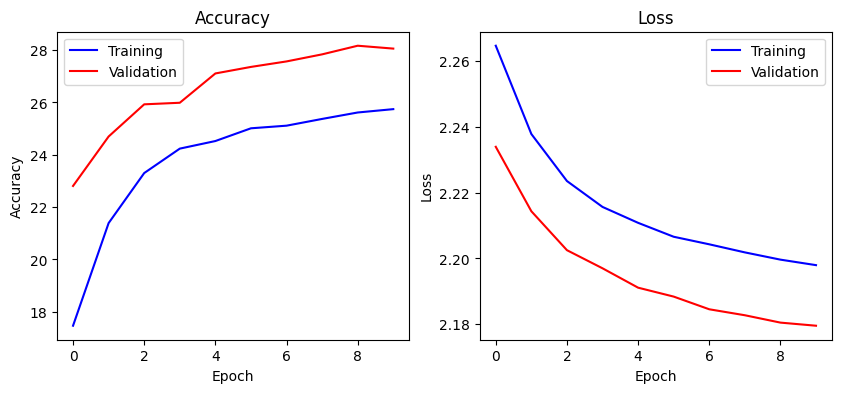

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].set_title("Accuracy")
axes[0].plot(range(epochs), train_acc_nn, 'b', label='Training')
axes[0].plot(range(epochs), val_acc_nn, 'r', label='Validation')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].legend()

axes[1].set_title("Loss")
axes[1].plot(range(epochs), train_loss_nn, 'b', label='Training')
axes[1].plot(range(epochs), val_loss_nn, 'r', label='Validation')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].legend()

## CNN

In [56]:
import math

def feature_map_dim(input_dim, padding, kernel_size, stride):
  return math.floor(((input_dim - kernel_size + 2 * padding) / stride) + 1)

In [ ]:
c1_conv_out = feature_map_dim(28, 0, 5, 1)
c1_out = feature_map_dim(c1_conv_out, 0, 2, 2)
conv_out = feature_map_dim(c1_out, 0, 5, 1)
c2_out = feature_map_dim(conv_out, 0, 2, 2)
c2_out

In [57]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, padding=0, kernel_size=5, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(p=0.2)
    )

    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, padding=0, kernel_size=5, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(p=0.2)
    )

    c1_conv_out = feature_map_dim(32, 0, 5, 1)
    c1_out = feature_map_dim(c1_conv_out, 0, 2, 2)
    conv_out = feature_map_dim(c1_out, 0, 5, 1)
    c2_out = feature_map_dim(conv_out, 0, 2, 2)

    self.flatten = nn.Flatten(start_dim=1)
    self.fc1 = nn.Linear(64 * c2_out * c2_out, 64 * c2_out)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(64 * c2_out, 64)
    self.fc3 = nn.Linear(64, 10)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    outputs = self.conv2(self.conv1(x))
    outputs = self.flatten(outputs)
    outputs = self.relu(self.fc1(outputs))
    outputs = self.relu(self.fc2(outputs))
    return self.softmax(self.fc3(outputs))

In [58]:
cnn_model = CNN()
optimizer = optim.Adam(cnn_model.parameters(), lr=1e-5, weight_decay=0.001) # L2 regularization 
criterion = nn.CrossEntropyLoss()
cnn_model.to(device)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1600, out_features=320, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=320, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

In [59]:
train_acc_cnn, train_loss_cnn, val_acc_cnn, val_loss_cnn = training(cnn_model, optimizer, criterion, train_loader, test_loader, epochs=epochs)

The loss for Epoch 0 is: 2.2786444057201014, Accuracy = 15.282
The loss for Epoch 1 is: 2.2214851034656213, Accuracy = 22.855
The loss for Epoch 2 is: 2.1996887218319143, Accuracy = 25.285
The loss for Epoch 3 is: 2.186087726707727, Accuracy = 26.866
The loss for Epoch 4 is: 2.1778082463196737, Accuracy = 27.741
The loss for Epoch 5 is: 2.171447906292789, Accuracy = 28.37
The loss for Epoch 6 is: 2.1652458060344517, Accuracy = 29.018
The loss for Epoch 7 is: 2.160960489408526, Accuracy = 29.449
The loss for Epoch 8 is: 2.155755626796837, Accuracy = 30.074
The loss for Epoch 9 is: 2.1507781638751333, Accuracy = 30.579


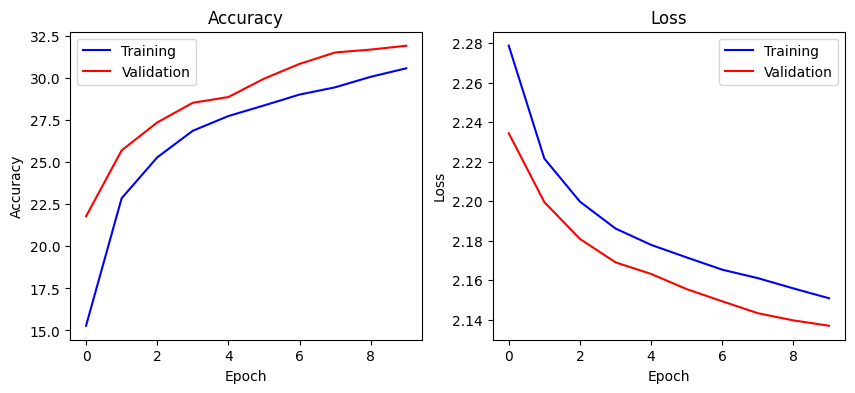

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].set_title("Accuracy")
axes[0].plot(range(epochs), train_acc_cnn, 'b', label='Training')
axes[0].plot(range(epochs), val_acc_cnn, 'r', label='Validation')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].legend()

axes[1].set_title("Loss")
axes[1].plot(range(epochs), train_loss_cnn, 'b', label='Training')
axes[1].plot(range(epochs), val_loss_cnn, 'r', label='Validation')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].legend()

# Pretrained Models

In [65]:
orig_transform = transforms.Compose([
  transforms.Resize((scale, scale)),
  transforms.ToTensor(),
  transforms.Normalize(mean=(0.1307), std=(0.3081))
])

train_data = datasets.CIFAR10(root='./data', train=True, transform=orig_transform, download=True)
test_data = datasets.CIFAR10(root='./data', train=False, transform=orig_transform, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [66]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch, shuffle=True, num_workers=0)

In [61]:
vgg_base = models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 62.2MB/s]


In [62]:
# Freeze layers
for param in vgg_base.parameters():
  param.requires_grad = False

# Modify the last layer 
num_classes = 10
in_features = vgg_base.classifier[-1].in_features
vgg_base.classifier[-1] = nn.Linear(in_features, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg_base.parameters(), lr=1e-5, weight_decay=0.001) # L2 regularization 

vgg_base.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [63]:
summary(vgg_base, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

In [67]:
train_acc_vgg, train_loss_vgg, val_acc_vgg, val_loss_vgg = training(vgg_base, optimizer, criterion, train_loader, test_loader, epochs=epochs)

The loss for Epoch 0 is: 2.087313948689824, Accuracy = 26.596
The loss for Epoch 1 is: 1.6338916137395307, Accuracy = 42.554
The loss for Epoch 2 is: 1.4954553228205123, Accuracy = 47.432
The loss for Epoch 3 is: 1.4310218641520156, Accuracy = 49.684
The loss for Epoch 4 is: 1.3854212122195213, Accuracy = 51.418
The loss for Epoch 5 is: 1.351056850398593, Accuracy = 52.748
The loss for Epoch 6 is: 1.327295157229504, Accuracy = 53.806
The loss for Epoch 7 is: 1.3047784074493076, Accuracy = 54.558
The loss for Epoch 8 is: 1.2840313896193833, Accuracy = 55.286
The loss for Epoch 9 is: 1.2695778574022796, Accuracy = 55.648


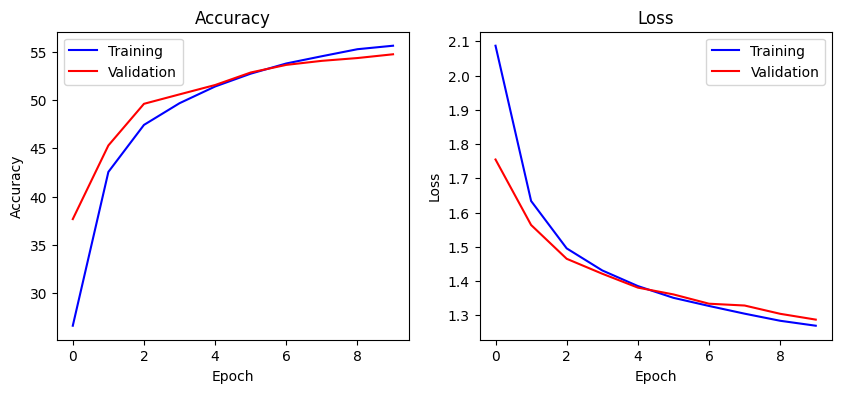

In [68]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].set_title("Accuracy")
axes[0].plot(range(epochs), train_acc_vgg, 'b', label='Training')
axes[0].plot(range(epochs), val_acc_vgg, 'r', label='Validation')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].legend()

axes[1].set_title("Loss")
axes[1].plot(range(epochs), train_loss_vgg, 'b', label='Training')
axes[1].plot(range(epochs), val_loss_vgg, 'r', label='Validation')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].legend()

# Confusion Matrix